## Jigsaw Multilingual Toxic Comment Classification
It only takes one toxic comment to sour an online discussion. The Conversation AI team, a research initiative founded by Jigsaw and Google, builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion. If these toxic contributions can be identified, we could have a safer, more collaborative internet.

In the previous 2018 Toxic Comment Classification Challenge, Kagglers built multi-headed models to recognize toxicity and several subtypes of toxicity. In 2019, in the Unintended Bias in Toxicity Classification Challenge, you worked to build toxicity models that operate fairly across a diverse range of conversations. This year, we're taking advantage of Kaggle's new TPU support and challenging you to build multilingual models with English-only training data.

Jigsaw's API, Perspective, serves toxicity models and others in a growing set of languages (see our documentation for the full list). Over the past year, the field has seen impressive multilingual capabilities from the latest model innovations, including few- and zero-shot learning. We're excited to learn whether these results "translate" (pun intended!) to toxicity classification. Your training data will be the English data provided for our previous two competitions and your test data will be Wikipedia talk page comments in several different languages.

As our computing resources and modeling capabilities grow, so does our potential to support healthy conversations across the globe. Develop strategies to build effective multilingual models and you'll help Conversation AI and the entire industry realize that potential.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

### What am I predicting?
You are predicting the probability that a comment is toxic. A toxic comment would receive a 1.0. A benign, non-toxic comment would receive a 0.0. In the test set, all comments are classified as either a 1.0 or a 0.0.

### Files
jigsaw-toxic-comment-train.csv - data from our first competition. The dataset is made up of English comments from Wikipedia’s talk page edits.
jigsaw-unintended-bias-train.csv - data from our second competition. This is an expanded version of the Civil Comments dataset with a range of additional labels.
sample_submission.csv - a sample submission file in the correct format
test.csv - comments from Wikipedia talk pages in different non-English languages.
validation.csv - comments from Wikipedia talk pages in different non-English languages.
jigsaw-toxic-comment-train-processed-seqlen128.csv - training data preprocessed for BERT
jigsaw-unintended-bias-train-processed-seqlen128.csv - training data preprocessed for BERT
validation-processed-seqlen128.csv - validation data preprocessed for BERT
test-processed-seqlen128.csv - test data preprocessed for BERT
### Columns
id - identifier within each file.
comment_text - the text of the comment to be classified.
lang - the language of the comment.
toxic - whether or not the comment is classified as toxic. (Does not exist in test.csv.)

In [65]:
import time
start = time.perf_counter()
import tensorflow as tf
print(tf.__version__)
end = time.perf_counter()
print('Elapsed time: ' + str(end - start))

2.4.1
Elapsed time: 0.000462800000605057


# EDA

In [66]:
import pandas as pd

start = time.perf_counter()
#loading data
train_data = pd.read_csv("data/jigsaw-toxic-comment-train.csv")
validation_data = pd.read_csv("data/validation.csv")
test_data = pd.read_csv("data/test.csv")
end = time.perf_counter()
print('Elapsed time: ' + str(end - start))

Elapsed time: 2.356315999999424


In [67]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [68]:
validation_data.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [69]:
test_data.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [70]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [71]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


Elapsed time: 36.40451539999958



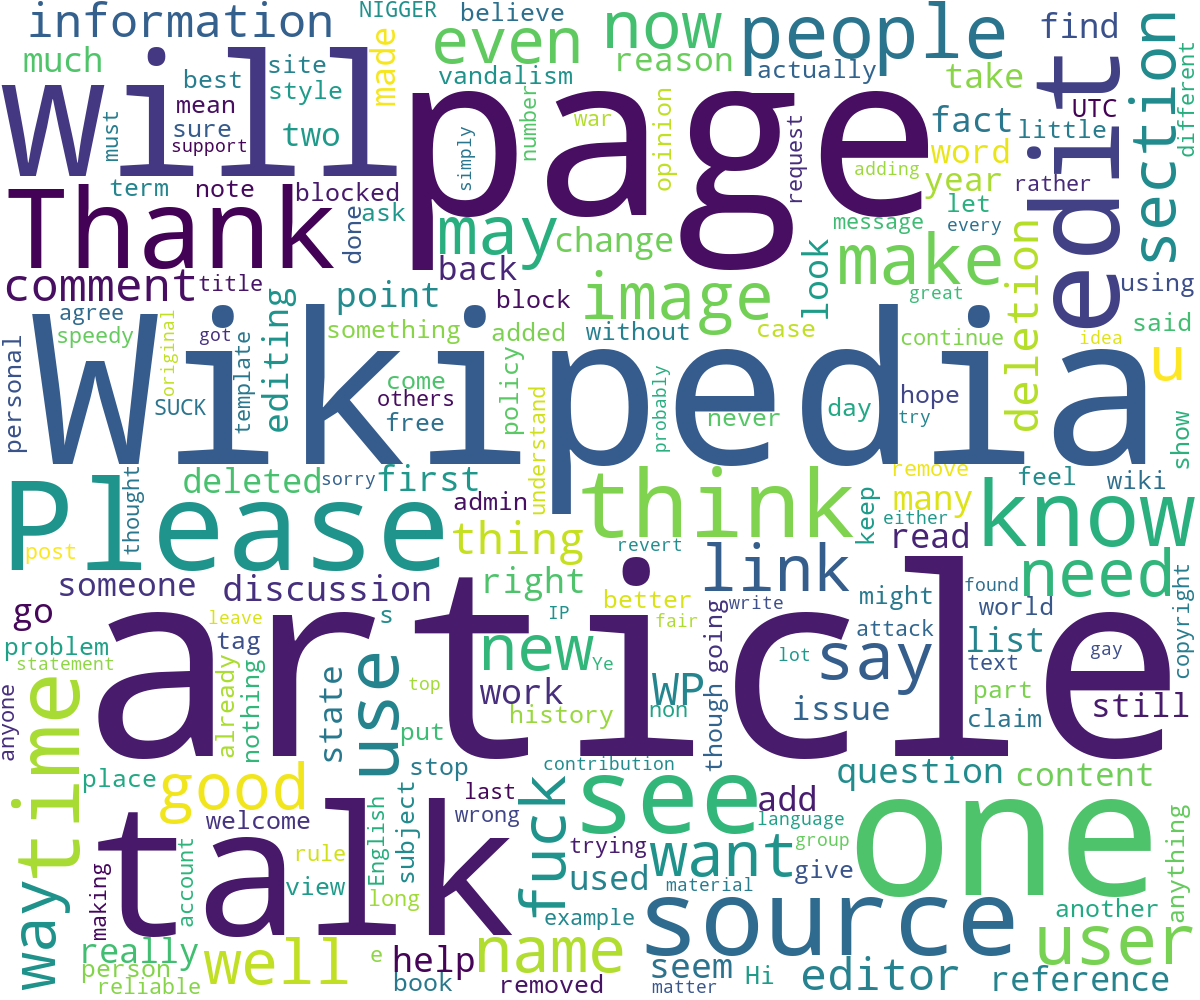

In [72]:
from wordcloud import WordCloud
import plotly.express as px

start = time.perf_counter()
def nonan(x):
    if type(x) == str:
        return x.replace("\n", "")
    else:
        return ""

text = ' '.join([nonan(abstract) for abstract in train_data["comment_text"]])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)

end = time.perf_counter()
print('Elapsed time: ' + str(end - start))
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Common words in comments')


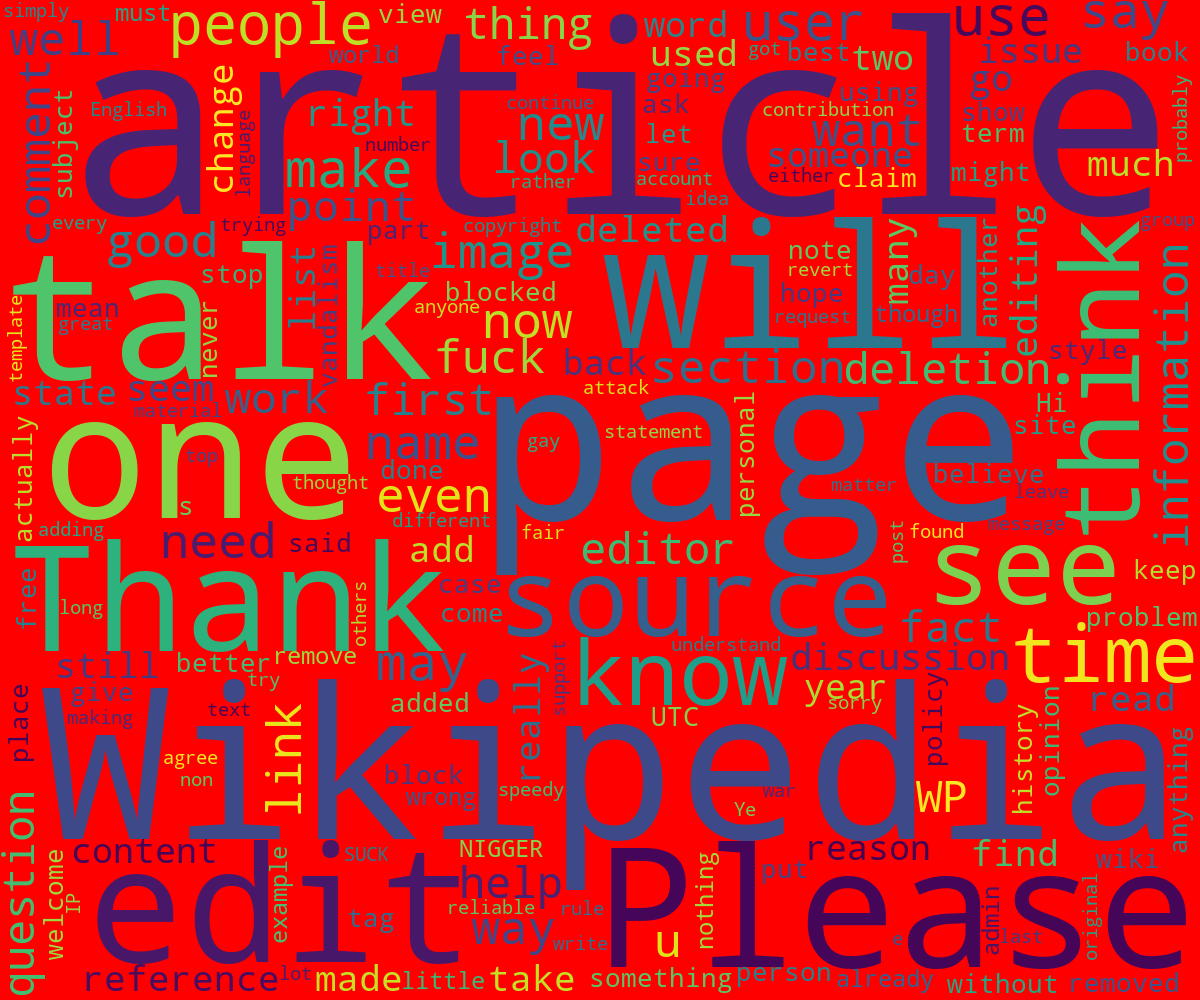

In [73]:
start = time.perf_counter()
wordcloud = WordCloud(max_font_size=None, background_color='red', collocations=False,
                      width=1200, height=1000).generate(text)
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Common words in comments')

#end = time.perf_counter()
#print('Elapsed time: ' + str(end - start))

### Cleaing Text

In [74]:
#checking 

In [75]:
#installing tweet-preprocessor
!pip install tweet-preprocessor
import preprocessor as p
p.set_options(p.OPT.URL,p.OPT.MENTION, p.OPT.SMILEY,p.OPT.EMOJI)

In [76]:
# Remove usernames and links
import re

val = validation_data
train = train_data
def clean_text(text):
    # fill the missing entries and convert them to lower case
    text = text.fillna("fillna").str.lower()
    # replace the newline characters with space 
    text = text.map(lambda x: re.sub('\\n',' ',str(x)))
    text = text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    # remove usernames and links
    text = text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    text = text.map(lambda x: re.sub("\(http://.*?\s\(http://.*\)",'',str(x)))
    return text

start = time.perf_counter()
val["comment_text"] = clean_text(val["comment_text"])
end = time.perf_counter()
print('Elapsed time: ' + str(end - start))


start = time.perf_counter()
test_data["content"] = clean_text(test_data["content"])
end = time.perf_counter()
print('Elapsed time: ' + str(end - start))

start = time.perf_counter()
train["comment_text"] = clean_text(train["comment_text"])
end = time.perf_counter()
print('Elapsed time: ' + str(end - start))

Elapsed time: 0.17736839999997756
Elapsed time: 1.4072297000002436
Elapsed time: 4.577925100000357


In [77]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" more i can't make any real suggestions on im...",0,0,0,0,0,0
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0


In [78]:
validation_data.head()

,id,comment_text,lang,toxic
0,0,este usuario ni siquiera llega al rango de ...,es,0
1,1,il testo di questa voce pare esser scopiazzato...,it,0
2,2,vale. sólo expongo mi pasado. todo tiempo pasa...,es,1
3,3,bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [79]:
test_data.head()

,id,content,lang
0,0,doctor who adlı viki başlığına 12. doctor olar...,tr
1,1,"вполне возможно, но я пока не вижу необходимо...",ru
2,2,"quindi tu sei uno di quelli conservativi , ...",it
3,3,malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:resim:seldabagcan.jpg resminde kaynak sorunu ...,tr
